In [205]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm
from numba import cuda
# import nvtx
import cupy as cp
import numba as nb

# # for pytorch
# from torch import zeros, cp.array, roll, sin, sqrt, linspace
# from torch import sum as tsum
# import torch

In [206]:
# print("Torch version:",torch.__version__)

# torch.cuda.get_device_name(0)


# Initialize NVTX Range Push/Pop functions
# nvtx_range_push = nvtx.annotate("Initialization")
# nvtx_range_pop = nvtx.annotate("Initialization")

In [207]:
# selecting device as cuda if available otherwise will set to cpu
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [208]:
# # @nb.jit(nopython=True)
# @cuda.jit
# def macroscopic(rho, u, fin, nx, ny, v):
#     rho = cp.sum(fin,axis=0)    # sending data to device
#     # rho_gpu = cuda.to_device(rho)
#     u = cp.zeros((2,nx,ny))  # sending data to device
#     # u_gpu = cuda.to_device(u)
#     # i = cuda.grid(1)
#     for i in range(9):
#         u[0,:,:] += v[i,0]*fin[i,:,:]
#         u[1,:,:] += v[i,1]*fin[i,:,:]
#     u /= rho
#     # return rho, u


@cuda.jit
def macroscopic(rho, u, fin, nx, ny, v):
    i, j = cuda.grid(2)
    
    if i < nx and j < ny:
        rho[i, j] = 0.0
        u[i, j, 0] = 0.0
        u[i, j, 1] = 0.0
        for k in range(9):
            rho[i, j] += fin[k, i, j]
            u[i, j, 0] += fin[k, i, j] * v[k, 0]
            u[i, j, 1] += fin[k, i, j] * v[k, 1]
        u[i, j, 0] /= rho[i, j]
        u[i, j, 1] /= rho[i, j]


In [209]:
# @nb.jit(nopython=True)
# @cuda.jit
# def equilibrium(rho, u, v, t, nx, ny):
#     usqr = (3/2)*(u[0]**2+u[1]**2)
#     feq = cp.zeros((9,nx,ny))
#     # i = cuda.grid(1)
#     for i in range(9):
#         cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
#         feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
#     return feq


# @cuda.jit
# def equilibrium(feq, rho, u, v, t):
#     nx, ny = u.shape
#     usqr = (3/2)*(u[0]**2 + u[1]**2)
#     i, j = cuda.grid(2)
#     if i < nx and j < ny:
#         for k in range(9):
#             cu = 3*(v[k,0]*u[0,i,j] + v[k,1]*u[1,i,j])
#             feq[k,i,j] = rho*t[k]*(1 + cu + 0.5*cu**2 - usqr[i,j])



# @cuda.jit
# def equilibrium(feq, rho, u, v, t):
#     nx, ny = u.shape
#     i, j = cuda.grid(2)
    
#     if i < nx and j < ny:
#         usqr = (3/2)*(u[i, j, 0]**2 + u[i, j, 1]**2)
#         for k in range(9):
#             cu = 3*(v[k, 0]*u[i, j, 0] + v[k, 1]*u[i, j, 1])
#             feq[k, i, j] = rho*t[k]*(1 + cu + 0.5*cu**2 - usqr)


@cuda.jit
def equilibrium(feq, rho, u, v, t):
    nx, ny, _ = u.shape
    i, j = cuda.grid(2)
    
    if i < nx and j < ny:
        usqr = (3/2)*(u[i, j, 0]**2 + u[i, j, 1]**2)
        for k in range(9):
            cu = 3*(v[k, 0]*u[i, j, 0] + v[k, 1]*u[i, j, 1])
            feq[k, i, j] = rho*t[k]*(1 + cu + 0.5*cu**2 - usqr)

In [210]:

def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner


In [211]:
# @nb.jit(nopython=True)
# @cuda.jit
# def inivel(uLB, ly, d, nx, ny):
#     # _,yy = cp.meshgrid(cp.linspace(0, nx - 1, nx), cp.linspace(0, ny - 1, ny))
#     yy_np, _ = np.meshgrid(np.linspace(0, ny - 1, ny), np.linspace(0, nx - 1, nx))
#     yy = cp.asarray(yy_np)
#     yy = yy.T
#     # yy = yy.T
#     # yy.to(device)
#     # vel = zeros((d, nx, ny)).to(device)
#     vel = cp.zeros((d, nx, ny))
#     for dir in range(d):
#         vel[dir,:,:] = (1-dir) * uLB * (1+1e-4*cp.sin(yy/ly*2*cp.pi))
#     return vel


# def inivel(uLB, ly, d, nx, ny):
#     _,yy = cp.meshgrid(cp.linspace(0, nx - 1, nx), cp.linspace(0, ny - 1, ny))
#     yy = yy.T
#     # yy.to(device)
#     # vel = zeros((d, nx, ny)).to(device)
#     vel = cp.zeros((d, nx, ny))
#     for dir in range(d):
#         vel[dir,:,:] = (1-dir) * uLB * (1+1e-4*cp.sin(yy/ly*2*cp.pi))
#     return vel


# def inivel( uLB, ly):
#     def inner(d,x,y):
#         return (1-d) * uLB * (1+1e-4*cp.sin(y/ly*2*np.pi))
#     return inner

# # @cuda.jit
# def inivel(uLB, ly, d, nx, ny):
#     # Create meshgrid manually
#     yy = cp.linspace(0, ny - 1, ny).repeat(nx).reshape((ny, nx))
#     # Transpose yy to match the required shape
#     yy = yy.T
#     vel = cp.zeros((d, nx, ny))
#     for dir in range(d):
#         vel[dir,:,:] = (1-dir) * uLB * (1 + 1e-4 * cp.sin(yy / ly * 2 * cp.pi))
#     return vel


def inivel(uLB, ly, d, nx, ny):
    yy = cp.linspace(0, ny - 1, ny).repeat(nx).reshape((ny, nx))
    yy = yy.T
    vel = cp.zeros((d, nx, ny))
    for dir in range(d):
        vel[dir,:,:] = (1-dir) * uLB * (1 + 1e-4 * cp.sin(yy / ly * 2 * cp.pi))
    return vel


In [212]:
Re = 50.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 70000
nx,ny = 720,380             # Domain dimensions
ly = ny-1
uLB = 0.04                  # Inlet velocity NON PHYSICAL??
cx,cy,r = nx//4,ny//2,ny/9  # cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity
omega = 1 / (3*nulb+0.5)    # Relaxation parameter


In [213]:

# lattice velocities
v = cp.array([
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

# weights
t = cp.array([
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ])

In [214]:
col_0 = cp.array([0,1,2])
col_1 = cp.array([3,4,5])
col_2 = cp.array([6,7,8])



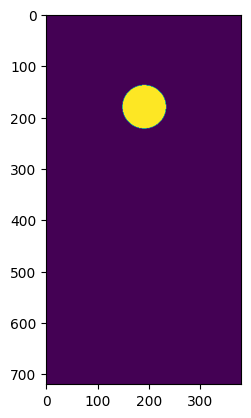

In [215]:
# kwargs['shape'] = [nx, ny]
# instantiate the cylindrical obstacle
obstacle = cp.array(cp.fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
ob = obstacle.get()
if True:
  plt.imshow(ob)


In [252]:

# initial velocity profile
# vel = cp.fromfunction(inivel(uLB,ly),(2,nx,ny))
# Pass Numpy arrays to Numba function
# blockspergrid = (nx, ny)  # Adjust as needed
# threadsperblock = (16, 16)  # Adjust as needed

# Call the CUDA kernel function with the specified launch configuration
# vel = inivel[blockspergrid, threadsperblock](uLB, ly, 2, nx, ny)

# vel = inivel(uLB, ly, 2, nx, ny)

# # tpb = 16
# # size = 10000
# # block = (size // tpb)
# # initialize fin to equilibirum (rho = 1)
# # fin = equilibrium[block, tpb](1,vel,v,t,nx,ny)
# # fin = equilibrium(1, vel_np, v, t, nx, ny)
# # vel_np = cp.asnumpy(vel)

# # fin = equilibrium(1,vel,v,t,nx,ny)


# feq = np.zeros((9, 10, 10))  # Allocate memory for the result
# threadsperblock = (16, 16)
# blockspergrid_x = (vel.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
# blockspergrid_y = (vel.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
# blockspergrid = (blockspergrid_x, blockspergrid_y)

# equilibrium[blockspergrid, threadsperblock](feq, 1, vel, v, t)



vel = inivel(uLB, ly, 2, nx, ny)

fin = cp.zeros((9, 10, 10))  # Allocate memory for the result
threadsperblock = (16, 16)
blockspergrid_x = (vel.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (vel.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Call the equilibrium kernel function
equilibrium[blockspergrid, threadsperblock](fin, 1, vel, v, t)
# fin = equilibrium[blockspergrid, threadsperblock](1, vel, v, t, nx, ny)

#==============================================================================
#   Time-Stepping
#==============================================================================
# t0 = ti()
# for time in tqdm(range(maxIter)):
#     # outflow boundary condition (right side) NEUMANN BC! No gradient
#     fin[col_2,-1,:] = fin[col_2,-2,:]
#     # compute macroscopic variables

#     rho = cp.zeros((nx, ny))
#     u = cp.zeros((nx, ny, 2))
#     macroscopic[blockspergrid, threadsperblock](rho, u, fin,nx,ny,v)
#     # rho,u = macroscopic(fin,nx,ny,v)

#     # inlet boundary condition (left wall)
#     # u[:,0,:] = vel[:,0,:]
#     # u[:,0,:] = vel[:,0,:].T
#     u[0, :, :] = vel[:, 0, :].T    # try this
#     rho[0,:] = 1/(1-u[0,0,:])*( cp.sum(fin[col_1,0,:], axis = 0)+
#                                 2*cp.sum(fin[col_2,0,:], axis = 0))

#     # feq = equilibrium(rho,u,v,t,nx,ny)
#     fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

#     # Collide
#     fout = fin - omega*(fin-feq)

#     # bounceback
#     for i in range(9):
#         fout[i,obstacle] = fin[8-i,obstacle]

#     # stream
#     for i in range(9):
#         # be careful with this -> numpy.roll cycles through an array by an axis
#         # and the last element becomes the first. this implements a periodic
#         # boundary in a very compact syntax, but needs to be reworked for other
#         # implementations
#         fin[i,:,:] = cp.roll(
#                           cp.roll(
#                                 fout[i,:,:], v[i,0], axis = 0
#                                ),
#                           v[i,1], axis = 1
#                           )

#     # Output an image every 100 iterations
#     if (time%100 == 0):
#         plt.clf()
#         u_temp = u.get()
#         # x_temp = int(round(5 * nx / ny))
#         # y_temp = int(round(5))
#         plt.imshow(np.sqrt(u_temp[0]**2+u_temp[1]**2).T, cmap= 'Reds')
#         plt.savefig("./testFolder/vel{0:03d}.png".format(time//100))
# tf = ti() - t0

# print("time to execute = ",tf)


def compute_rho(fin_col_1, fin_col_2, u_0):
    return 1 / (1 - u_0) * (cp.sum(fin_col_1, axis=0) + 2 * cp.sum(fin_col_2, axis=0))

# Define the time-stepping loop
def time_stepping(maxIter, nx, ny, obstacle, vel, v, t, omega):
    t0 = ti()
    for time in tqdm(range(maxIter)):
        # Outflow boundary condition (right side)
        fin[2, -1, :] = fin[2, -2, :]

        # Compute macroscopic variables
        rho = cp.zeros((nx, ny))
        # u = cp.zeros((nx, ny, 2))
        u = cp.zeros((nx, ny, 2))
        macroscopic[blockspergrid, threadsperblock](rho, u, fin, nx, ny, v)
        
        # Inlet boundary condition (left wall)
        # u[0, :, :] = vel[:, 0, :].T
        # u[0, 0, :] = u[0, 0, :].reshape(-1)
        
        # Modified code
        # u[0, :, :] = vel[:, 0, :].T
        # # Reshape u[0, 0, :] to have the same shape as fin[0, 0, :]
        # u[0, 0, :] = cp.tile(u[0, 0, :], (10 // u.shape[-1],)) 

        # u[0, :, :] = vel[:, 0, :].T
        # Repeat each element of u[0, 0, :] to match the desired length of (10,)
        # u[0, :, :] = vel[:, 0, :]
        # print(f"{vel.T.reshape((nx, ny, 2)).shape}")
        # print(f"{u[0, :, :].shape}")
        # u[0, :, :] = vel.T.reshape((nx, ny, 2))
        # print(f"{vel.T.shape}")
        # u[0, :, :] = vel.reshape((ny, 2))
        # u[0, :, :] = vel.T.reshape((ny, 2))
        # u[0, :, :] = vel.reshape((nx, 2))
        # u[0, :, :] = vel.T.reshape(( ny, 2))
        u[0, :, :] = vel.transpose(1, 2, 0)
        # Repeat each element of u[0, 0, :] to match the desired length of (10,)
        # u[0, 0, :] = cp.repeat(u[0, 0, :], 5)
        # u[0, 0, :] = cp.tile(u[0, 0, :], (10 // u.shape[-1],))
        rho[0, :] = compute_rho(fin[0, 0, :], fin[2, 0, :], u[0, 0, :])
        # rho[0,:] = 1/(1-u[0,0,:])*( cp.sum(fin[col_1,0,:], axis = 0) + 2*cp.sum(fin[col_2,0,:], axis = 0))
        
        # Collide
        fout = fin - omega * (fin - feq)

        # Bounce-back
        for i in range(9):
            fout[i, obstacle] = fin[8 - i, obstacle]

        # Stream
        for i in range(9):
            fin[i, :, :] = cp.roll(cp.roll(fout[i, :, :], v[i, 0], axis=0), v[i, 1], axis=1)

        # Output an image every 100 iterations
        if time % 100 == 0:
            plt.clf()
            u_temp = u.get()
            plt.imshow(np.sqrt(u_temp[0]**2 + u_temp[1]**2).T, cmap='Reds')
            plt.savefig(f"./testFolder/vel{time//100:03d}.png")

    tf = ti() - t0
    print("Time to execute:", tf)

In [253]:
time_stepping(maxIter, nx, ny, obstacle, vel, v, t, omega)

  0%|                                                                                       | 0/70000 [00:00<?, ?it/s]


ValueError: Out shape is mismatched

In [ ]:
# ! nsys profile python3 fSimCupy.py

In [219]:
print(f"vel shape = {vel.shape} and u shape = {u.shape}")

vel shape = (2, 720, 380) and u shape = (720, 380, 2)


In [254]:
! python3 testFinal.py

/home/cisco581b/.local/lib/python3.8/site-packages/cupy/_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
  2%|▋                                     | 1330/70000 [00:26<23:05, 49.56it/s]
Traceback (most recent call last):
  Fil